# Setup

First, import modules and codes from modules to run this notebook:

In [1]:
from IPython.display import display

from brightway2 import *
import bw2analyzer as bwa
import brightway2 as bw
from bw2data.parameters import *
from lci_to_bw2 import *
from bw2data.project import ProjectManager
from bw2data.parameters import (ActivityParameter, DatabaseParameter,
                                ProjectParameter, Group)

import pandas as pd
import numpy as np

import math

import pathlib

import sqlite3

import os

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

Defining a few global parameters:

In [2]:
# Defining the directory with datasets:
ROOT_DIR = "files"

In [3]:
# Defining the size of figures:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [4]:
# Defining the path where to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\IMG


In [5]:
# Defining seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.25,
                rc={"axes.titlesize": 12, "lines.linewidth": 1,
                    "legend.fontsize": 8, "legend.title_fontsize": 10})

In [6]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [7]:
# Listing the available Brightway2 projects:
bw.projects

Brightway2 projects manager with 5 objects:
	LCA_Glazing
	LCA_Glazing_0
	LCOPT_Setup
	default
	test
Use `projects.report()` to get a report on all projects.

In [8]:
# Creating a new project or accessing an existing one:
bw.projects.set_current("LCA_Glazing")

# Locating the current project:
bw.projects.dir

'C:\\Users\\souvi\\AppData\\Local\\pylca\\Brightway3\\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab'

# List of Scenarios with their Parameters

All scenarios and their parameters for the LCA are defined in the Excel file called lca_scenarios. Here it is imported.

In [9]:
lca_scenarios = pd.ExcelFile(os.path.join(ROOT_DIR, "lca_scenarios.xlsx"))

# Printng the list of sheets in the Excel file:
print("lca_scenarios, sheet names = \n {}\n".format(lca_scenarios.sheet_names))

lca_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16']



Creating a set of DataFrames. One for each calculation step, which corresponds to a batch of simulations defined by a specific building configuration with different types of IGUs:

In [10]:
# Creating one DataFrame per step:
df_step1 = lca_scenarios.parse('Step1').set_index('name')
df_step2 = lca_scenarios.parse('Step2').set_index('name')
df_step3 = lca_scenarios.parse('Step3').set_index('name')
df_step4 = lca_scenarios.parse('Step4').set_index('name')
df_step5 = lca_scenarios.parse('Step5').set_index('name')
df_step6 = lca_scenarios.parse('Step6').set_index('name')
df_step7 = lca_scenarios.parse('Step7').set_index('name')
df_step8 = lca_scenarios.parse('Step8').set_index('name')
df_step9 = lca_scenarios.parse('Step9').set_index('name')
df_step10 = lca_scenarios.parse('Step10').set_index('name')
df_step11 = lca_scenarios.parse('Step11').set_index('name')
df_step12 = lca_scenarios.parse('Step12').set_index('name')
df_step13 = lca_scenarios.parse('Step13').set_index('name')
df_step14 = lca_scenarios.parse('Step14').set_index('name')
df_step15 = lca_scenarios.parse('Step15').set_index('name')
df_step16 = lca_scenarios.parse('Step16').set_index('name')

# Import of LCA Databases

Importing databases that include LCIA methods, global life cycle inventories (Ecoinvent and Biosphere 3) and those that are specific to this study (saved as Excel files in the subfolder "files").

In [11]:
# Print the databases already available in the current project:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

## Ecoinvent and Biosphere 3

**Importing Biosphere 3:**

Biosphere 3 is the default biosphere database with all the resource and emission flows from the ecoinvent database, version 2.

In [12]:
# Importing elementary flows, LCIA methods and some other data
bw.bw2setup()

Biosphere database already present!!! No setup is needed


**Importing Ecoinvent 3.7, cut-off system model:**

For more information about the system models in ecoinvent, and especially the cut-off one, read [this](https://ecoinvent.org/the-ecoinvent-database/system-models/).

In [13]:
# Importing the ecoinvent 3.7 cut-off database, saved locally:
ei37cutdir = (r"C:\Users\souvi\Documents\These\80_Calculations\06_LCA_SystemDiagrams\02_Dataset\ecoinvent 3.7_cutoff_ecoSpold02\datasets")

if 'ecoinvent 3.7 cut-off' in databases:
    print("Database has already been imported!")
else:
    ei37cut = bw.SingleOutputEcospold2Importer(
        ei37cutdir, 'ecoinvent 3.7 cut-off')
    ei37cut.apply_strategies()
    ei37cut.statistics()
    ei37cut.write_database()

Database has already been imported!


## Excel Datasets

Import of the life cycle inventory specific to this case study and saved in the Excel files.

<font color='red'>But first, a boolean variable to specify if importing (or updating) the inventory is necessary:<font>

In [14]:
import_exldb = True

**Importing the Excel dataset relating to aluminium production, regionalised for the case study:**

In [15]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_alu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()

    # Checking whether the import went as expected.
    # Creating an Excel sheet with process data:
    imp.write_excel()

    # Writing the data to a database to save it:
    imp.write_database()

Extracted 2 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


2 datasets
12 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_alu.xlsx


0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:35
  Finished: 02/18/2022 22:34:35
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.25
Created database: exldb_alu


**Importing the Excel dataset relating to silica sand production, regionalised for the case study:**

In [16]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_silica_sand.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 2 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


2 datasets
29 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_sand.xlsx


0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:37
  Finished: 02/18/2022 22:34:37
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.31
Created database: exldb_sand


**Importing the Excel dataset relating to the insulating glass units:**

In [17]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_igu.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_sand",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()

    # Adding the project-level parameters:
    imp.write_project_parameters()

    # Writing the data to a database to save it:
    imp.write_database()

Extracted 44 worksheets in 0.35 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.20 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
44 datasets
381 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_igu.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:40
  Finished: 02/18/2022 22:34:40
  Total time elapsed: 00:00:00
  CPU %: 67.20
  Memory %: 1.44
Created database: exldb_igu


**Importing the Excel dataset relating to double glazing w/ different types of spacers:**

In [18]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_spacers.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 13 worksheets in 0.10 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
13 datasets
183 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_spacers.xlsx


0% [#############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:42
  Finished: 02/18/2022 22:34:42
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 1.38
Created database: exldb_spacers


**Importing the Excel dataset relating to the end-of-life phase of curtain wall façades:**

In [19]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw_eol.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 28 worksheets in 0.23 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


28 datasets
108 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw_eol.xlsx


0% [############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:45
  Finished: 02/18/2022 22:34:45
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39
Created database: exldb_cw_eol


**Importing the Excel dataset relating to the production and use of curtain wall façades:**

In [20]:
if import_exldb:
    imp = bw.ExcelImporter(os.path.join(ROOT_DIR, "lci_cw.xlsx"))
    imp.apply_strategies()
    imp.match_database(fields=('name', 'unit', 'location'))
    imp.match_database("ecoinvent 3.7 cut-off",
                       fields=('name', 'unit', 'location'))
    imp.match_database("exldb_igu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_alu",
                       fields=('name', 'unit', 'location', 'input'))
    imp.match_database("exldb_cw_eol",
                       fields=('name', 'unit', 'location', 'input'))
    imp.statistics()
    imp.write_excel()
    imp.write_database()

Extracted 48 worksheets in 0.32 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.23 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
48 datasets
260 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\souvi\AppData\Local\pylca\Brightway3\LCA_Glazing.d2e1ffa0d7e38b337d42880125eeaeab\output\db-matching-exldb_cw.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/18/2022 22:34:47
  Finished: 02/18/2022 22:34:47
  Total time elapsed: 00:00:00
  CPU %: 120.20
  Memory %: 1.43
Created database: exldb_cw


**Checking if the imports went well:**

List databases:

In [21]:
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cut-off
	exldb_alu
	exldb_cw
	exldb_cw_eol
	exldb_igu
	exldb_sand
	exldb_spacers

Checking Excel database:

**Deleting a database, if needed:**

## Navigating Databases

Assigning a variable to each database to ease their use:

In [22]:
eib3db = bw.Database('biosphere3')

eicutdb = bw.Database('ecoinvent 3.7 cut-off')

exldb_alu = bw.Database('exldb_alu')
exldb_igu = bw.Database('exldb_igu')
exldb_cw = bw.Database('exldb_cw')
exldb_spacers = bw.Database('exldb_spacers')
exldb_cw_eol = bw.Database('exldb_cw_eol')

# Defining the Parameters

## Overview

Checking the total number of parameters:

In [23]:
len(parameters)

61

Listing the parameters:

In [24]:
if len(ProjectParameter.select()) !=0:
    print("\033[1m", "Project parameters:", "\033[0m")
    for p in ProjectParameter.select():
        print(p.name, ":", p.amount)

print("------")
print("\033[1m", "Database parameters:", "\033[0m")
for p in DatabaseParameter.select():
    print(p.database, " > ", p.name, ":", round(p.amount, 2))

 Project parameters: 
param_g_density : 2.5
param_t_lsg : 10.0
param_t_tsg : 10.0
param_n_pvb : 2.0
param_d1 : 125.0
param_t_g_ext : 8.0
param_t_g_mid_tg : 6.0
param_t_g_uncoated_int : 8.0
------
 Database parameters: 
exldb_cw_eol  >  param_g_density : 2.5
exldb_cw_eol  >  param_t_lsg : 10.0
exldb_cw_eol  >  param_t_tsg : 10.0
exldb_cw_eol  >  param_n_pvb : 2.0
exldb_cw_eol  >  param_d1 : 125.0
exldb_cw_eol  >  param_t_g_ext : 8.0
exldb_cw_eol  >  param_t_g_mid_tg : 6.0
exldb_cw_eol  >  param_t_g_uncoated_int : 8.0
exldb_cw_eol  >  param_m_sg_g : 25.0
exldb_cw_eol  >  param_m_sg_alu : 3.31
exldb_cw_eol  >  param_m_sg_low_wood : 0.09
exldb_cw_eol  >  param_m_sg_low_silicone : 0.15
exldb_cw_eol  >  param_m_sg_high_epdm : 0.55
exldb_cw_eol  >  param_m_dg_g : 45.0
exldb_cw_eol  >  param_m_dg_alu : 3.47
exldb_cw_eol  >  param_m_dg_low_wood : 0.09
exldb_cw_eol  >  param_m_dg_low_silicone : 0.15
exldb_cw_eol  >  param_m_dg_high_epdm : 0.67
exldb_cw_eol  >  param_m_tg_g : 60.0
exldb_cw_eol  >

## Activating the Parameters

This step consists in asking Brightway2 to activate the exchanges and their formulas:

In [25]:
# Adding exchanges with formulas from activity to group:
for act in exldb_igu:
    parameters.add_exchanges_to_group("igu_param_group", act)

In [26]:
# Creating a list of activity data
ls_act_data_cw_eol = []

n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw_eol"):
    ls_act_data_cw_eol.append({'name': obj.name, 'amount': obj.amount,
                               'formula': obj.formula, 'database': obj.database,
                              'code': "p_eol_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw_eol, "cw_eol_param_group", overwrite=True)

In [27]:
for act in exldb_cw_eol:
    parameters.add_exchanges_to_group("cw_eol_param_group", act)

In [28]:
ls_act_data_cw = []
n_code = 0
for obj in DatabaseParameter.select().where(
        DatabaseParameter.database == "exldb_cw"):
    ls_act_data_cw.append({'name': obj.name, 'amount': obj.amount,
                           'formula': obj.formula, 'database': obj.database,
                           'code': "p_"+str(n_code)})
    n_code += 1

parameters.new_activity_parameters(
    ls_act_data_cw, "cw_use_param_group", overwrite=True)

In [29]:
for act in exldb_cw:
    parameters.add_exchanges_to_group("cw_use_param_group", act)

Then we calculate the "activated" formula values:

In [30]:
ActivityParameter.recalculate_exchanges("igu_param_group")
ActivityParameter.recalculate_exchanges("cw_use_param_group")
ActivityParameter.recalculate_exchanges("cw_eol_param_group")

**Delete the parameters:**

In [31]:
# delete the table of existing project parameters, i.e. actually deletes the project parameters
ProjectParameter.drop_table(safe=True, drop_sequences=True)

# LCIA Methods

List of available LCIA methods:

Define methods:

In [32]:
method_ilcd_gwp = (
    'ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')

In [33]:
methods_small = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

In [34]:
methods_full = [
    ('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality',
     'freshwater and terrestrial acidification'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation'),
    ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'fossils'),
    ('ILCD 2.0 2018 midpoint', 'resources', 'land use')
]

# Weighting

The weighting step is done according to the factors for all midpoint impact categories according to :

Sala, Serenella, Alessandro Kim Cerutti, and Rana Pant. ‘Development of a Weighting Approach for the Environmental Footprint’. Luxembourg: Publications Office of the European Union, 2018. https://ec.europa.eu/environment/eussd/smgp/documents/2018_JRC_Weighting_EF.pdf.

In [35]:
# Matching impact labels between the Ecovinvent ILCD 2018 method
# and the report by Sala et al.:
dict_ilcd_to_weight = {
    ('climate change', 'climate change total'):(
        "Climate change"),
    ('human health', 'ozone layer depletion'): (
        "Ozone depletion"),
    ('human health', 'carcinogenic effects'): (
        "Human toxicity, cancer effects"),
    ('human health', 'non-carcinogenic effects'): (
        "Human toxicity, non-cancer effects"),
    ('human health', 'respiratory effects, inorganics'): (
        "Particulate matter"),
    ('human health', 'ionising radiation'): (
        "Ionizing radiation, human health"),
    ('human health', 'photochemical ozone creation'): (
        "Photochemical ozone formation, human health"),
    ('ecosystem quality', 'freshwater and terrestrial acidification'): (
        "Acidification"),
    ('ecosystem quality', 'terrestrial eutrophication'): (
        "Eutrophication, terrestrial"),
    ('ecosystem quality', 'freshwater eutrophication'): (
        "Eutrophication, freshwater"),
    ('ecosystem quality', 'marine eutrophication'): (
        "Eutrophication, marine"),
    ('ecosystem quality', 'freshwater ecotoxicity'): (
        "Ecotoxicity freshwater"),
    ('resources', 'land use'): (
        "Land use"),
    ('resources', 'dissipated water'): (
        "Water use"),
    ('resources', 'minerals and metals'): (
        "Resource use, minerals and metals"),
    ('resources', 'fossils'): (
        "Resource use, fossils")
}

In [36]:
# List of weighting factors by impact category:
dict_weighting = {"Climate change": 21.06,
                  "Ozone depletion": 6.31,
                  "Human toxicity, cancer effects": 2.13,
                  "Human toxicity, non-cancer effects": 1.84,
                  "Particulate matter": 8.96,
                  "Ionizing radiation, human health": 5.01,
                  "Photochemical ozone formation, human health": 4.78,
                  "Acidification": 6.20,
                  "Eutrophication, terrestrial": 3.71,
                  "Eutrophication, freshwater": 2.80,
                  "Eutrophication, marine": 2.96,
                  "Ecotoxicity freshwater": 1.92,
                  "Land use": 7.94,
                  "Water use": 8.51,
                  "Resource use, minerals and metals": 7.55,
                  "Resource use, fossils": 8.32
                  }

In [37]:
df_weighting = pd.DataFrame.from_dict(dict_ilcd_to_weight, orient='index',
                                      columns=['Weighting factor'])

for key, value in dict_weighting.items():
    df_weighting.loc[df_weighting['Weighting factor'] == key, 
                     'Weighting factor'] = value
    
    df_weighting.index = pd.MultiIndex.from_tuples(
        df_weighting.index, names=['Category','Subcategory']
    )

In [38]:
df_weighting

Weighting factor
Category          Subcategory                                              
climate change    climate change total                                21.06
human health      ozone layer depletion                                6.31
                  carcinogenic effects                                 2.13
                  non-carcinogenic effects                             1.84
                  respiratory effects, inorganics                      8.96
                  ionising radiation                                   5.01
                  photochemical ozone creation                         4.78
ecosystem quality freshwater and terrestrial acidification              6.2
                  terrestrial eutrophication                           3.71
                  freshwater eutrophication                             2.8
                  marine eutrophication                                2.96
                  freshwater ecotoxicity                               1.92
resources         land use                                             7.94
                  dissipated water                                     8.51
                  minerals and metals                                  7.55
                  fossils                                              8.32

# LCA of Flat Glasses and IGUs from Cradle to Gate

## Flat Glass Production

Define the <font color='red'> functional unit </font> per flat glass (fg) type:

In [39]:
inv_fg_unsorted = [act for act in exldb_igu
                   if 'market for flat glass' in act['name']
                   ]

inv_fg = sorted(inv_fg_unsorted,
                key=lambda k: k['name'])

inv_fg

['market for flat glass, coated' (kilogram, BE, ('building components', 'windows')),
 'market for flat glass, uncoated' (kilogram, BE, ('building components', 'windows'))]

In [40]:
names_fg_processed = ['market for laminated safety glass',
                      'market for tempered safety glass',
                      'market for smart glass'
                      ]

inv_fg_processed_unsorted = [act for act in exldb_igu
                             for n in names_fg_processed
                             if n in act['name']
                             and "glazing" not in act['name']
                             ]

inv_fg_processed = sorted(inv_fg_processed_unsorted,
                          key=lambda k: k['name'])

inv_fg_processed

['market for laminated safety glass' (square meter, BE, ('building components', 'windows')),
 'market for laminated safety glass, coated' (square meter, BE, ('building components', 'windows')),
 'market for smart glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass' (square meter, BE, ('building components', 'windows')),
 'market for tempered safety glass, coated' (square meter, BE, ('building components', 'windows'))]

In [41]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

impact_fg = []

for act in inv_fg:
    lca = bw.LCA({act: fu_fg})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impact_fg.append((act["name"], act["location"],
                           method[1], lca.score,
                           bw.methods.get(method).get('unit')))

for act in inv_fg_processed:
    lca = bw.LCA({act: fu_fg_processed})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impact_fg.append((act["name"], act["location"],
                           method[1], lca.score,
                           bw.methods.get(method).get('unit')))

# impact_fg

In [42]:
df_impact_fg = pd.DataFrame(impact_fg, columns=["Name", "Location", "Method",
                                                  "Score", "Unit"])

df_impact_fg = pd.pivot_table(df_impact_fg, index=["Name"],
                               columns=["Method", "Unit"],
                               values="Score")

In [43]:
df_impact_fg = df_impact_fg.sort_values(
    ("climate change", "kg CO2-Eq"), ascending=True)

df_impact_fg.round(2)

Method                                    climate change ecosystem quality  \
Unit                                           kg CO2-Eq               CTU   
Name                                                                         
market for flat glass, uncoated                    27.11              7.08   
market for flat glass, coated                      28.71              9.15   
market for tempered safety glass                   29.22              7.31   
market for tempered safety glass, coated           30.86              9.41   
market for laminated safety glass                  36.93             12.35   
market for laminated safety glass, coated          37.75             13.40   
market for smart glass                            542.85           1338.69   

Method                                                                \
Unit                                      kg P-Eq mol H+-Eq mol N-Eq   
Name                                                                   
market for flat glass, uncoated              0.00      0.22     0.60   
market for flat glass, coated                0.00      0.24     0.63   
market for tempered safety glass             0.00      0.23     0.62   
market for tempered safety glass, coated     0.00      0.24     0.65   
market for laminated safety glass            0.01      0.26     0.69   
market for laminated safety glass, coated    0.01      0.27     0.70   
market for smart glass                       0.04      2.27     7.39   

Method                                    human health            resources  \
Unit                                        kg CFC-11. kg NMVOC-. megajoule   
Name                                                                          
market for flat glass, uncoated                    0.0       0.14    344.41   
market for flat glass, coated                      0.0       0.15    377.57   
market for tempered safety glass                   0.0       0.15    377.22   
market for tempered safety glass, coated           0.0       0.15    411.04   
market for laminated safety glass                  0.0       0.17    623.93   
market for laminated safety glass, coated          0.0       0.17    640.85   
market for smart glass                             0.0       2.21   8464.07   

Method                                              
Unit                                        points  
Name                                                
market for flat glass, uncoated             104.18  
market for flat glass, coated               146.02  
market for tempered safety glass            106.57  
market for tempered safety glass, coated    149.25  
market for laminated safety glass           196.82  
market for laminated safety glass, coated   218.16  
market for smart glass                     7881.78

In [44]:
df_impact_fg = df_impact_fg.reset_index()
df_impact_fg['Name'] = (df_impact_fg['Name']
                         .str.replace('market for ', ''))

df_impact_fg = df_impact_fg.set_index('Name')

In [45]:
df_impact_wo_smartg = df_impact_fg.drop("smart glass", axis=0)

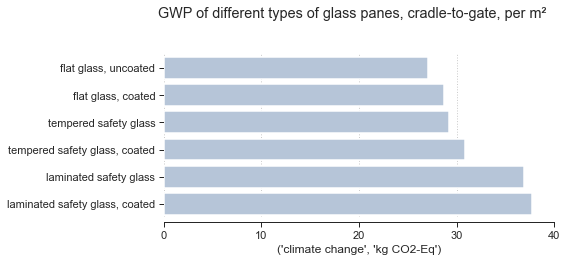

In [46]:
fig, ax = plt.subplots(figsize=(7, 3))

sns.barplot(data=df_impact_wo_smartg,
            x=("climate change", "kg CO2-Eq"),
            y=df_impact_wo_smartg.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 40)
plt.xticks(np.arange(0, 41, 10))

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, per m²', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [47]:
df_norm_impact_wo_smartg = (
    df_impact_wo_smartg / df_impact_wo_smartg.max()
)
df_norm_impact_wo_smartg.round(2)

Method                         climate change ecosystem quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.72              0.53    0.47   
flat glass, coated                       0.76              0.68    0.59   
tempered safety glass                    0.77              0.55    0.48   
tempered safety glass, coated            0.82              0.70    0.60   
laminated safety glass                   0.98              0.92    0.94   
laminated safety glass, coated           1.00              1.00    1.00   

Method                                            human health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.84     0.86         0.49       0.83   
flat glass, coated                  0.89     0.90         0.51       0.88   
tempered safety glass               0.86     0.88         0.54       0.86   
tempered safety glass, coated       0.91     0.92         0.56       0.90   
laminated safety glass              0.97     0.98         0.99       0.98   
laminated safety glass, coated      1.00     1.00         1.00       1.00   

Method                         resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.54   0.48  
flat glass, coated                  0.59   0.67  
tempered safety glass               0.59   0.49  
tempered safety glass, coated       0.64   0.68  
laminated safety glass              0.97   0.90  
laminated safety glass, coated      1.00   1.00

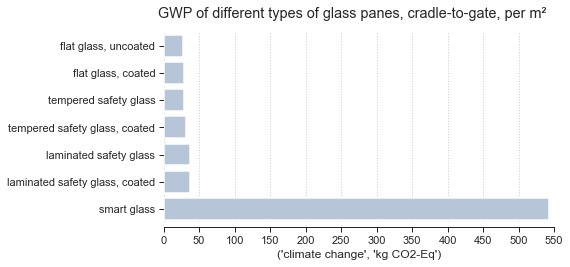

In [48]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sns.barplot(data=df_impact_fg,
            x=("climate change", "kg CO2-Eq"),
            y=df_impact_fg.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 550)
plt.xticks(np.arange(0, 551, 50))

fig.suptitle(
    'GWP of different types of glass panes, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [49]:
df_norm_impact_fg = df_impact_fg / df_impact_fg.max()
df_norm_impact_fg.round(2)

Method                         climate change ecosystem quality          \
Unit                                kg CO2-Eq               CTU kg P-Eq   
Name                                                                      
flat glass, uncoated                     0.05              0.01    0.06   
flat glass, coated                       0.05              0.01    0.07   
tempered safety glass                    0.05              0.01    0.06   
tempered safety glass, coated            0.06              0.01    0.08   
laminated safety glass                   0.07              0.01    0.12   
laminated safety glass, coated           0.07              0.01    0.13   
smart glass                              1.00              1.00    1.00   

Method                                            human health             \
Unit                           mol H+-Eq mol N-Eq   kg CFC-11. kg NMVOC-.   
Name                                                                        
flat glass, uncoated                0.10     0.08         0.02       0.06   
flat glass, coated                  0.10     0.09         0.02       0.07   
tempered safety glass               0.10     0.08         0.02       0.07   
tempered safety glass, coated       0.11     0.09         0.03       0.07   
laminated safety glass              0.11     0.09         0.04       0.08   
laminated safety glass, coated      0.12     0.10         0.04       0.08   
smart glass                         1.00     1.00         1.00       1.00   

Method                         resources         
Unit                           megajoule points  
Name                                             
flat glass, uncoated                0.04   0.01  
flat glass, coated                  0.04   0.02  
tempered safety glass               0.04   0.01  
tempered safety glass, coated       0.05   0.02  
laminated safety glass              0.07   0.02  
laminated safety glass, coated      0.08   0.03  
smart glass                         1.00   1.00

**Same calculation, but using the MultiLCA class with the full list of impact categories (ILCD midpoint):**

In [50]:
# functional unit; 25kg of glass to obtain a thickness of 10mm for 1m²:
fu_fg = 25
# functional unit; 1m²:
fu_fg_processed = 1

mlca_syst_fg = []

for act in inv_fg:
    mlca_syst_fg.append({act.key: fu_fg})

for act in inv_fg_processed:
    mlca_syst_fg.append({act.key: fu_fg_processed})

mlca_syst_fg

[{('exldb_igu', 'market_glass_coated'): 25},
 {('exldb_igu', 'market_glass_uncoated'): 25},
 {('exldb_igu', 'market_lsg'): 1},
 {('exldb_igu', 'market_lsg_coated'): 1},
 {('exldb_igu', 'market_smartglass'): 1},
 {('exldb_igu', 'market_tsg'): 1},
 {('exldb_igu', 'market_tsg_coated'): 1}]

In [51]:
bw.calculation_setups['calculation_setup'] = {'inv': mlca_syst_fg,
                                              'ia': methods_full}

mlca = bw.MultiLCA('calculation_setup')
df_impact_mlca_fg = pd.DataFrame(data=mlca.results, columns=mlca.methods)

In [52]:
activities = [(get_activity(key), amount)
              for dct in mlca.func_units
              for key, amount in dct.items()
              ]

df_fu = pd.DataFrame([(x['name'], x['database'], x['code'],
                       x['location'], x['unit'], y)
                      for x, y in activities],
                     columns=('Database', 'Code', 'Name',
                              'Location', 'Unit', 'Amount')
                     )

df_impact_mlca_fg_expanded = pd.concat(
    [df_fu, df_impact_mlca_fg], axis=1
)

In [53]:
df_impact_mlca_fg_expanded = (
    df_impact_mlca_fg_expanded.set_index("Name")
    .drop(["Database", "Code", "Location", "Unit", "Amount"], axis=1)
)

In [54]:
df_impact_mlca_fg_expanded.columns = pd.MultiIndex.from_tuples(
    df_impact_mlca_fg_expanded.columns, names=('Method', 'Category', 'Subcategory')
)

In [55]:
df_impact_mlca_fg_expanded = df_impact_mlca_fg_expanded.sort_values(
    by=[('ILCD 2.0 2018 midpoint', 'climate change', 'climate change total')],
    ascending=True)

In [56]:
df_impact_mlca_fg_expanded.columns = (
    pd.MultiIndex.from_tuples(df_impact_mlca_fg_expanded.columns,
                              names=["method", "Category", "Subcategory"]
                              )
)

In [57]:
df_impact_mlca_fg_expanded["ILCD 2.0 2018 midpoint"].round(2).T

Name                                                        market_glass_uncoated  \
Category          Subcategory                                                       
climate change    climate change total                                      27.11   
ecosystem quality freshwater ecotoxicity                                     7.08   
                  freshwater and terrestrial acidification                   0.22   
                  freshwater eutrophication                                  0.00   
                  marine eutrophication                                      0.05   
                  terrestrial eutrophication                                 0.60   
human health      non-carcinogenic effects                                   0.00   
                  carcinogenic effects                                       0.00   
                  ionising radiation                                         3.11   
                  ozone layer depletion                                      0.00   
                  photochemical ozone creation                               0.14   
                  respiratory effects, inorganics                            0.00   
resources         minerals and metals                                        0.00   
                  dissipated water                                           6.04   
                  fossils                                                  344.41   
                  land use                                                 104.18   

Name                                                        market_glass_coated  \
Category          Subcategory                                                     
climate change    climate change total                                    28.71   
ecosystem quality freshwater ecotoxicity                                   9.15   
                  freshwater and terrestrial acidification                 0.24   
                  freshwater eutrophication                                0.00   
                  marine eutrophication                                    0.05   
                  terrestrial eutrophication                               0.63   
human health      non-carcinogenic effects                                 0.00   
                  carcinogenic effects                                     0.00   
                  ionising radiation                                       3.89   
                  ozone layer depletion                                    0.00   
                  photochemical ozone creation                             0.15   
                  respiratory effects, inorganics                          0.00   
resources         minerals and metals                                      0.00   
                  dissipated water                                         6.75   
                  fossils                                                377.57   
                  land use                                               146.02   

Name                                                        market_tsg  \
Category          Subcategory                                            
climate change    climate change total                           29.22   
ecosystem quality freshwater ecotoxicity                          7.31   
                  freshwater and terrestrial acidification        0.23   
                  freshwater eutrophication                       0.00   
                  marine eutrophication                           0.05   
                  terrestrial eutrophication                      0.62   
human health      non-carcinogenic effects                        0.00   
                  carcinogenic effects                            0.00   
                  ionising radiation                              3.19   
                  ozone layer depletion                           0.00   
                  photochemical ozone creation                    0.15   
            

In [58]:
df_norm_impact_mlca_fg_expanded = (
    df_impact_mlca_fg_expanded.drop("market_smartglass")
    / df_impact_mlca_fg_expanded.drop("market_smartglass").max()
)

df_norm_impact_mlca_fg_expanded["ILCD 2.0 2018 midpoint"].round(2).T

Name                                                        market_glass_uncoated  \
Category          Subcategory                                                       
climate change    climate change total                                       0.72   
ecosystem quality freshwater ecotoxicity                                     0.53   
                  freshwater and terrestrial acidification                   0.84   
                  freshwater eutrophication                                  0.47   
                  marine eutrophication                                      0.84   
                  terrestrial eutrophication                                 0.86   
human health      non-carcinogenic effects                                   0.48   
                  carcinogenic effects                                       0.49   
                  ionising radiation                                         0.32   
                  ozone layer depletion                                      0.49   
                  photochemical ozone creation                               0.83   
                  respiratory effects, inorganics                            0.86   
resources         minerals and metals                                        0.62   
                  dissipated water                                           0.51   
                  fossils                                                    0.54   
                  land use                                                   0.48   

Name                                                        market_glass_coated  \
Category          Subcategory                                                     
climate change    climate change total                                     0.76   
ecosystem quality freshwater ecotoxicity                                   0.68   
                  freshwater and terrestrial acidification                 0.89   
                  freshwater eutrophication                                0.59   
                  marine eutrophication                                    0.88   
                  terrestrial eutrophication                               0.90   
human health      non-carcinogenic effects                                 0.66   
                  carcinogenic effects                                     0.70   
                  ionising radiation                                       0.41   
                  ozone layer depletion                                    0.51   
                  photochemical ozone creation                             0.88   
                  respiratory effects, inorganics                          0.90   
resources         minerals and metals                                      0.91   
                  dissipated water                                         0.56   
                  fossils                                                  0.59   
                  land use                                                 0.67   

Name                                                        market_tsg  \
Category          Subcategory                                            
climate change    climate change total                            0.77   
ecosystem quality freshwater ecotoxicity                          0.55   
                  freshwater and terrestrial acidification        0.86   
                  freshwater eutrophication                       0.48   
                  marine eutrophication                           0.87   
                  terrestrial eutrophication                      0.88   
human health      non-carcinogenic effects                        0.49   
                  carcinogenic effects                            0.51   
                  ionising radiation                              0.33   
                  ozone layer depletion                           0.54   
                  photochemical ozone creation                    0.86   
            

In [59]:
df_norm_impact_mlca_fg_expanded.columns = (
    df_norm_impact_mlca_fg_expanded.columns.droplevel([0, 1])
)

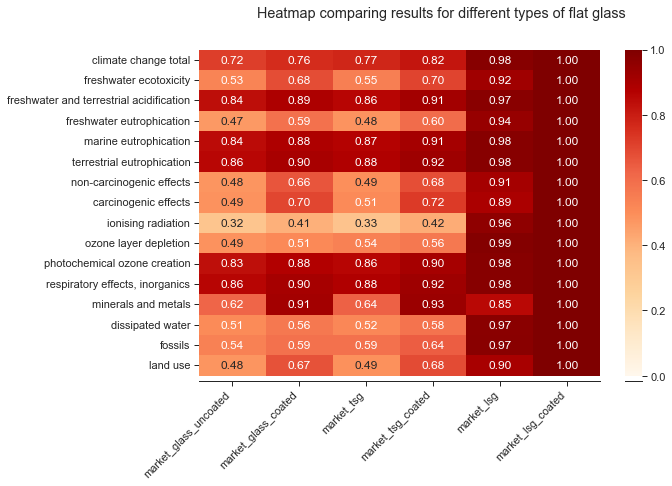

In [60]:
fig, ax = plt.subplots(figsize=(9, 6))

df_plot = df_norm_impact_mlca_fg_expanded.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f')

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing results for different types of flat glass')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

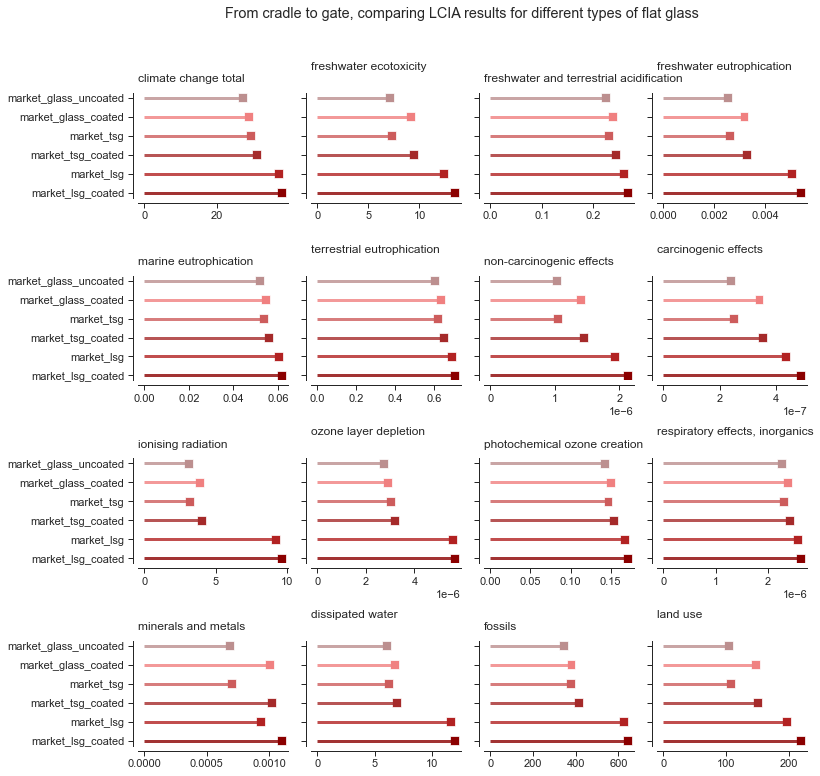

In [61]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(12, 12))

df_plot = df_impact_mlca_fg_expanded.drop("market_smartglass")
df_plot.columns = (df_plot.columns.droplevel([0, 1]))

c = ["rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)
        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        # sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)
        if (n % 2) == 0:
            ax.set_title(col_name, y=1.05, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name, y=1.17, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'From cradle to gate, comparing LCIA results' +
    ' for different types of flat glass')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparison of different types of flat glass according to a single indicator calculated using PEF weighting factors:

In [62]:
# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_fg = pd.DataFrame((df_impact_mlca_fg_expanded["ILCD 2.0 2018 midpoint"]
                  .multiply(df_weighting["Weighting factor"].T, axis=1) / 100
                 ).sum(axis=1), columns=['Weighted impact'])

df_weighted_fg

,Weighted impact
Name,
market_glass_uncoated,43.487143
market_glass_coated,50.047313
market_tsg,46.874804
market_tsg_coated,53.566178
market_lsg,77.051885
market_lsg_coated,80.397571
market_smartglass,1477.659478


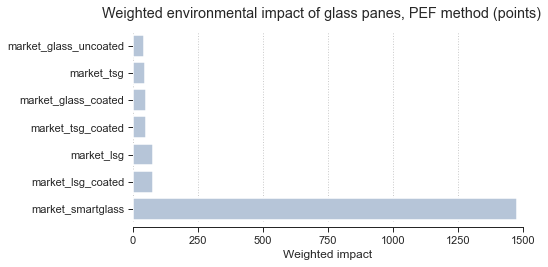

In [63]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 3.5))

df_plot = df_weighted_fg.sort_values("Weighted impact", ascending=True)

sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 1500)
plt.xticks(np.arange(0, 1501, 250))

fig.suptitle('Weighted environmental impact of glass panes,' 
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

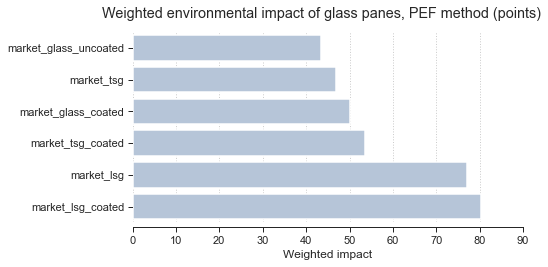

In [64]:
# Printing a barplot figure with the weighted results w/o smart glass:
fig, ax = plt.subplots(figsize=(7, 3.5))

df_plot = (df_weighted_fg.drop("market_smartglass")
           .sort_values("Weighted impact", ascending=True)
          )

sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 90)
plt.xticks(np.arange(0, 91, 10))

fig.suptitle('Weighted environmental impact of glass panes,' 
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

## Impact of Different Types of Spacers, Sealants and Insulating Gases, Cradle-to-Gate

### Comparative Analysis of Spacers

In [65]:
inv_spacers = [act for act in bw.Database("exldb_spacers")
               if 'krypton' not in act['name']
               and 'xenon' not in act['name']
               and 'air' not in act['name']]

fu_spacers = [{igu: 1} for igu in inv_spacers]

In [66]:
impact_spacers = []

for igu in inv_spacers:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_full:
        lca.switch_method(method)
        lca.lcia()
        impact_spacers.append((igu["name"], igu["location"],
                                method[1], method[2], lca.score,
                                bw.methods.get(method).get('unit'))
                               )

In [67]:
df_impact_spacers = pd.DataFrame(
    impact_spacers,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

df_impact_spacers = pd.pivot_table(
    df_impact_spacers, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

In [68]:
df_impact_spacers = df_impact_spacers.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

df_impact_spacers = df_impact_spacers.reset_index()
df_impact_spacers['Name'] = (df_impact_spacers['Name']
                              .str.replace('double glazing production, ', '')
                              .str.replace(', argon', ''))

df_impact_spacers = df_impact_spacers.set_index('Name')

In [69]:
df_impact_spacers.round(2)

Category                              climate change  \
Subcategory                     climate change total   
Unit                                       kg CO2-Eq   
Name                                                   
without spacer                                 45.50   
composite with corrugated metal                46.37   
epdm foam                                      46.46   
single-seal aluminium                          46.59   
dual-seal aluminium                            46.67   
dual-seal steel                                46.68   
thermally broken aluminium                     46.84   
thermoplastic PIB                              46.93   
slicone foam                                   48.15   
dual-seal composite plastic                    58.58   

Category                                               ecosystem quality  \
Subcategory                     freshwater and terrestrial acidification   
Unit                                                           mol H+-Eq   
Name                                                                       
without spacer                                                      0.37   
composite with corrugated metal                                     0.37   
epdm foam                                                           0.38   
single-seal aluminium                                               0.38   
dual-seal aluminium                                                 0.38   
dual-seal steel                                                     0.38   
thermally broken aluminium                                          0.38   
thermoplastic PIB                                                   0.38   
slicone foam                                                        0.38   
dual-seal composite plastic                                         0.44   

Category                                                \
Subcategory                     freshwater ecotoxicity   
Unit                                               CTU   
Name                                                     
without spacer                                   13.69   
composite with corrugated metal                  14.13   
epdm foam                                        14.63   
single-seal aluminium                            16.82   
dual-seal aluminium                              16.89   
dual-seal steel                                  17.13   
thermally broken aluminium                       16.89   
thermoplastic PIB                                14.96   
slicone foam                                     15.42   
dual-seal composite plastic                      19.52   

Category                                                   \
Subcategory                     freshwater eutrophication   
Unit                                              kg P-Eq   
Name                                                        
without spacer                                       0.00   
composite with corrugated metal                      0.00   
epdm foam                                            0.01   
single-seal aluminium                                0.01   
dual-seal aluminium                                  0.01   
dual-seal steel                                      0.01   
thermally broken aluminium                           0.01   
thermoplastic PIB                                    0.01   
slicone foam                                         0.01   
dual-seal composite plastic                          0.01   

Category                                               \
Subcategory                     marine eutrophication   
Unit                                          kg N-Eq   
Name                                                    
without spacer                                   0.09   
composite with corrugated metal                  0.09   
epdm foam                                        0.09   
single-seal aluminium                            0.09   
dual-seal aluminium       

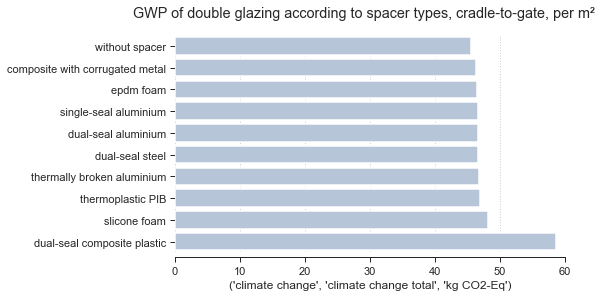

In [70]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impact_spacers,
            x=("climate change", "climate change total", "kg CO2-Eq"),
            y=df_impact_spacers.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 60)
plt.xticks(np.arange(0, 61, 10))

fig.suptitle(
    'GWP of double glazing according to spacer types, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [71]:
df_norm_impact_spacers = df_impact_spacers / df_impact_spacers.max()
df_norm_impact_spacers.round(2)

Category                              climate change  \
Subcategory                     climate change total   
Unit                                       kg CO2-Eq   
Name                                                   
without spacer                                  0.78   
composite with corrugated metal                 0.79   
epdm foam                                       0.79   
single-seal aluminium                           0.80   
dual-seal aluminium                             0.80   
dual-seal steel                                 0.80   
thermally broken aluminium                      0.80   
thermoplastic PIB                               0.80   
slicone foam                                    0.82   
dual-seal composite plastic                     1.00   

Category                                               ecosystem quality  \
Subcategory                     freshwater and terrestrial acidification   
Unit                                                           mol H+-Eq   
Name                                                                       
without spacer                                                      0.85   
composite with corrugated metal                                     0.85   
epdm foam                                                           0.86   
single-seal aluminium                                               0.86   
dual-seal aluminium                                                 0.86   
dual-seal steel                                                     0.86   
thermally broken aluminium                                          0.86   
thermoplastic PIB                                                   0.86   
slicone foam                                                        0.87   
dual-seal composite plastic                                         1.00   

Category                                                \
Subcategory                     freshwater ecotoxicity   
Unit                                               CTU   
Name                                                     
without spacer                                    0.70   
composite with corrugated metal                   0.72   
epdm foam                                         0.75   
single-seal aluminium                             0.86   
dual-seal aluminium                               0.87   
dual-seal steel                                   0.88   
thermally broken aluminium                        0.87   
thermoplastic PIB                                 0.77   
slicone foam                                      0.79   
dual-seal composite plastic                       1.00   

Category                                                   \
Subcategory                     freshwater eutrophication   
Unit                                              kg P-Eq   
Name                                                        
without spacer                                       0.50   
composite with corrugated metal                      0.52   
epdm foam                                            0.53   
single-seal aluminium                                0.55   
dual-seal aluminium                                  0.55   
dual-seal steel                                      0.55   
thermally broken aluminium                           0.56   
thermoplastic PIB                                    0.55   
slicone foam                                         0.58   
dual-seal composite plastic                          1.00   

Category                                               \
Subcategory                     marine eutrophication   
Unit                                          kg N-Eq   
Name                                                    
without spacer                                   0.88   
composite with corrugated metal                  0.89   
epdm foam                                        0.89   
single-seal aluminium                            0.90   
dual-seal aluminium       

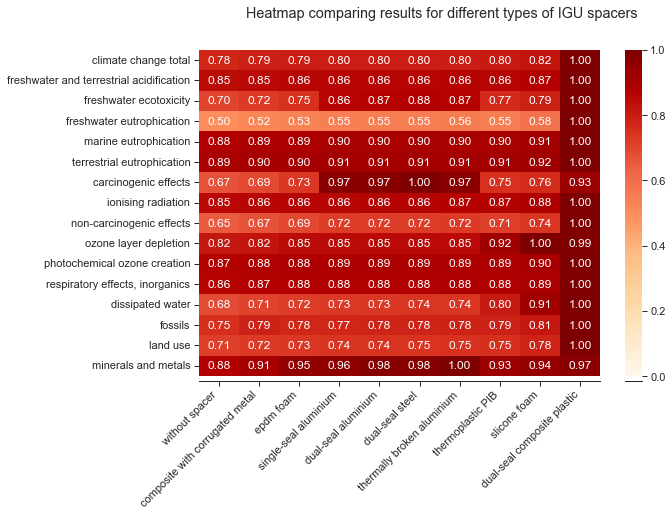

In [72]:
fig, ax = plt.subplots(figsize=(9, 6))

y_axis_labels = []
for label in df_norm_impact_spacers.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_spacers.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing results for different types of IGU spacers')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

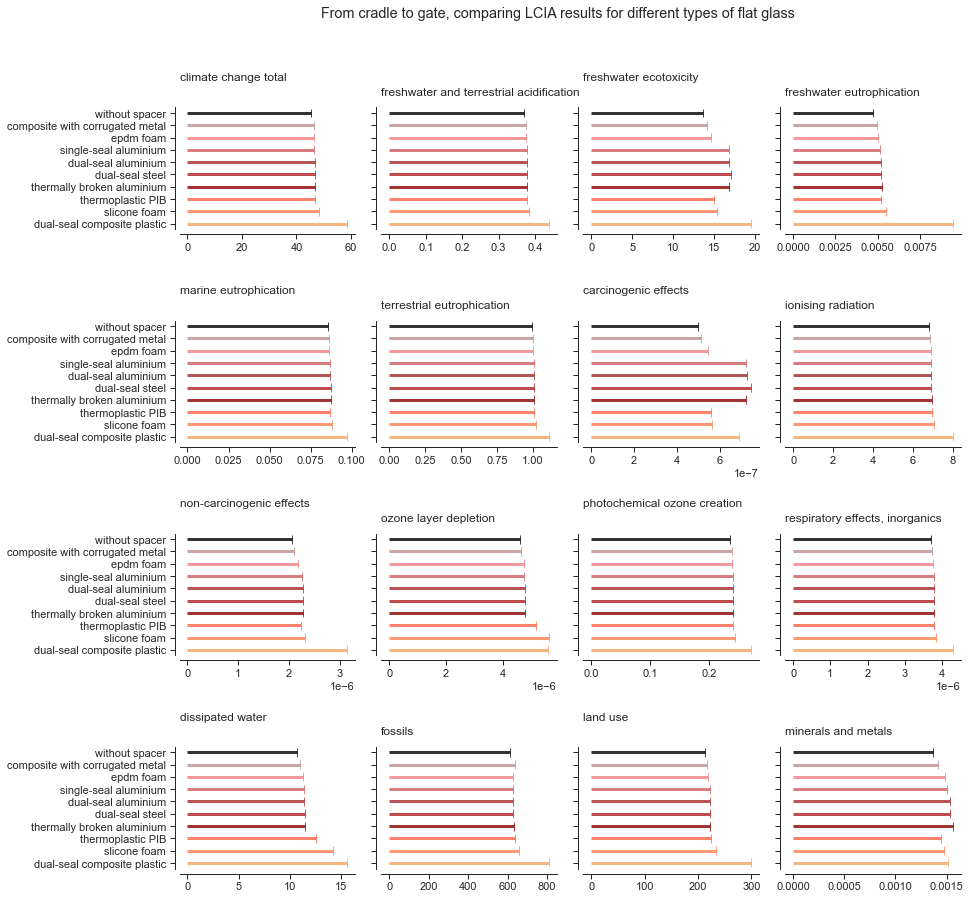

In [81]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 14))

df_plot = df_impact_spacers

c = ["black", "rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred",
     "tomato", "coral", "sandybrown"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)
        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        # sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)
        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.17, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.05, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'From cradle to gate, comparing LCIA results' +
    ' for different types of flat glass')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparison of different types of IGUs according to a single indicator calculated using PEF weighting factors:

In [75]:
# To ease the calculation, we drop the unit row index:
df_weighted_spacers = df_impact_spacers
df_weighted_spacers.columns = df_weighted_spacers.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_spacers = pd.DataFrame(
    (df_weighted_spacers.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
    ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_spacers

,Weighted impact
Name,
without spacer,78.872425
composite with corrugated metal,81.558729
epdm foam,81.205578
single-seal aluminium,81.340000
dual-seal aluminium,81.623840
dual-seal steel,81.657879
thermally broken aluminium,82.080301
thermoplastic PIB,82.420927
slicone foam,85.408988


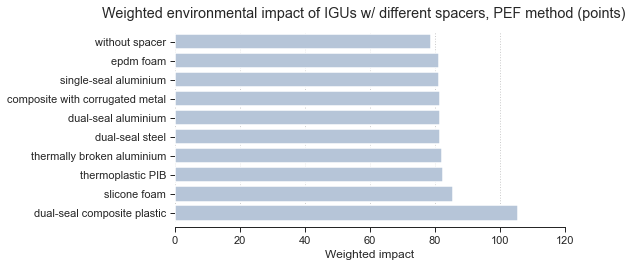

In [76]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 3.5))

df_plot = (df_weighted_spacers.sort_values("Weighted impact", ascending=True))

sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 120)
plt.xticks(np.arange(0, 121, 20))

fig.suptitle('Weighted environmental impact of IGUs w/ different spacers,' 
             ' PEF method (points)')
sns.despine(left=True, offset=5)
plt.show()

### Comparative Analysis of Insulating Gases

In [ ]:
inv_gas = [act for act in bw.Database("exldb_spacers")
           if 'thermally broken aluminium' in act['name']
           ]

fu_gas = [{igu: 1} for igu in inv_gas]
fu_gas

In [ ]:
impact_gas = []

for igu in inv_gas:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_full:
        lca.switch_method(method)
        lca.lcia()
        impact_gas.append((igu["name"], igu["location"],
                            method[1], method[2], lca.score,
                            bw.methods.get(method).get('unit')))

# impact_gas

In [ ]:
df_impact_gas = pd.DataFrame(
    impact_gas,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

df_impact_gas = pd.pivot_table(
    df_impact_gas, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

In [ ]:
df_impact_gas = df_impact_gas.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

df_impact_gas = df_impact_gas.reset_index()
df_impact_gas['Name'] = (df_impact_gas['Name']
                         .str.replace('double glazing production, ', '')
                         .str.replace('thermally broken aluminium, ', '')
                         )

df_impact_gas = df_impact_gas.set_index('Name')

In [ ]:
df_impact_gas.round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2))

sns.barplot(data=df_impact_gas,
            x=("climate change", "climate change total", "kg CO2-Eq"),
            y=df_impact_gas.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of double glazing according to insulating gas type,' +
    ' cradle-to-gate, per m²', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

In [ ]:
df_norm_impact_gas = df_impact_gas / df_impact_gas.max()
df_norm_impact_gas.round(2).sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 6))

y_axis_labels = []
for label in df_norm_impact_gas.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_gas.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing results for different types of IGU spacers')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 9))

df_plot = df_impact_gas

c = ["indianred", "brown", "firebrick", "darkred"]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)
        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        # sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)
        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.17, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.05, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'From cradle to gate, comparing LCIA results' +
    ' for different types of flat glass')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparison of different types of IGUs according to a single indicator calculated using PEF weighting factors:

In [ ]:
# To ease the calculation, we drop the unit row index:
df_weighted_gas = df_impact_gas
df_weighted_gas.columns = df_weighted_gas.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_gas = pd.DataFrame(
    (df_weighted_gas.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_gas

In [ ]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 2))

df_plot = (df_weighted_gas.sort_values("Weighted impact", ascending=True))

sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 140)
plt.xticks(np.arange(0, 141, 20))

fig.suptitle('Weighted environmental impact of IGUs w/ different spacers,' 
             ' PEF method (points)', y=1.1)
sns.despine(left=True, offset=5)
plt.show()

## Comparative LCA of Different Designs for IGU, Cradle-to-Gate

In [ ]:
inv_igus = [act for act in bw.Database("exldb_igu")
            if 'market' in act['name']
            and ('glazing' in act['name']
            or 'vacuum' in act['name'])
            ]

fu_igus = [{igu: 1} for igu in inv_igus]

fu_igus

In [ ]:
impact_igus = []

for igu in inv_igus:
    lca = bw.LCA({igu: 1})
    lca.lci()
    for method in methods_full:
        lca.switch_method(method)
        lca.lcia()
        impact_igus.append((igu["name"], igu["location"],
                             method[1], method[2], lca.score,
                             bw.methods.get(method).get('unit')))

# impact_igus

In [ ]:
df_impact_igus = pd.DataFrame(
    impact_igus,
    columns=["Name", "Location", "Category", "Subcategory", "Score", "Unit"]
)

df_impact_igus = pd.pivot_table(
    df_impact_igus, index=["Name"],
    columns=["Category", "Subcategory", "Unit"], values="Score"
)

In [ ]:
df_impact_igus = df_impact_igus.sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True
)

df_impact_igus = df_impact_igus.reset_index()
df_impact_igus['Name'] = (df_impact_igus['Name']
                           .str.replace('market for ', ''))

df_impact_igus = df_impact_igus.set_index('Name')

In [ ]:
df_impact_igus.round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

df_plot = df_impact_igus.drop("smart glass, double glazing", axis=0)

sns.barplot(data=df_plot,
            x=("climate change", "climate change total", "kg CO2-Eq"),
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [ ]:
df_norm_impact_igus_wo_smartg = (
    df_impact_igus.drop("smart glass, double glazing", axis=0) / 
    df_impact_igus.drop("smart glass, double glazing", axis=0).max()
)

df_norm_impact_igus_wo_smartg.round(2).sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(data=df_impact_igus,
            x=("climate change", "climate change total", "kg CO2-Eq"),
            y=df_impact_igus.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of different design of IGUs, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

In [ ]:
df_norm_impact_igus = (
    df_impact_igus.drop("smart glass, double glazing") / 
    df_impact_igus.drop("smart glass, double glazing").max()
)

df_norm_impact_igus.round(2).sort_values(
    ("climate change", "climate change total", "kg CO2-Eq"), ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

y_axis_labels = []
for label in df_norm_impact_igus.columns:
    y_axis_labels.append(label[1])

df_plot = df_norm_impact_igus.T

ax = sns.heatmap(df_plot, cmap="OrRd", vmin=0, vmax=1, annot=True, fmt='.2f',
                 yticklabels=y_axis_labels)

ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)

fig.suptitle(
    'Heatmap comparing results for different types of IGU spacers')
sns.despine(left=True, offset=5)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(14, 18))

df_plot = df_impact_igus.drop("smart glass, double glazing")

c = ["rosybrown", "lightcoral", "indianred",
     "brown", "firebrick", "darkred",
     "tomato", "coral", "sandybrown",
     "goldenrod", "olivedrab", "forestgreen",
     "green", "seagreen"
    ]

n = 0

for row in range(4):
    for col in range(4):
        col_name = df_plot.columns[n]
        ax = axes[row][col]

        ax.hlines(y=df_plot.index, xmin=0, xmax=df_plot[col_name],
                  linewidth=3, colors=c, alpha=0.8)
        sns.scatterplot(y=df_plot.index, x=df_plot[col_name],
                        hue=df_plot.index, s=80, marker="|",
                        palette=c, ax=ax)

        # sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)
        if (n % 2) == 0:
            ax.set_title(col_name[1], y=1.17, x=0,
                         ha='left', multialignment='left')
        else:
            ax.set_title(col_name[1], y=1.05, x=0,
                         ha='left', multialignment='left')

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.75)

fig.suptitle(
    'From cradle to gate, comparing LCIA results' +
    ' for different types of IGUs')
sns.despine(offset=5)
plt.show()

**Weighted environmental impact:**

Comparison of different types of IGUs according to a single indicator calculated using PEF weighting factors:

In [ ]:
# To ease the calculation, we drop the unit row index:
df_weighted_igus = df_impact_igus
df_weighted_igus.columns = df_weighted_igus.columns.droplevel(2)

# Defining a new DataFrame with the weighted values,
# i.e., multiplication of the impacts by df_weighting:
df_weighted_igus = pd.DataFrame(
    (df_weighted_igus.multiply(
        df_weighting["Weighting factor"].T, axis=1) / 100
     ).sum(axis=1), columns=['Weighted impact']
)

df_weighted_igus

In [ ]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

df_plot = (df_weighted_igus.sort_values("Weighted impact", ascending=True))

sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 2000)
plt.xticks(np.arange(0, 2001, 250))

fig.suptitle('Weighted environmental impact of IGUs,' 
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

In [ ]:
# Printing a barplot figure with the weighted results:
fig, ax = plt.subplots(figsize=(7, 6))

df_plot = (df_weighted_igus.drop("smart glass, double glazing")
           .sort_values("Weighted impact", ascending=True)
          )


sns.barplot(data=df_plot,
            x="Weighted impact",
            y=df_plot.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

ax.set_xlim(0, 275)
plt.xticks(np.arange(0, 276, 25))

fig.suptitle('Weighted environmental impact of IGUs,' 
             ' PEF method (points)', y=1)
sns.despine(left=True, offset=5)
plt.show()

# LCA of Curtain Wall Systems, from Cradle to Gate

## Environmental Impact

**Comparative analysis of different CW configurations:**

In [ ]:
inv_cw = [act for act in bw.Database("exldb_cw")
          if 'market for curtain wall' in act['name']
          # and 'xenon' not in act['name']
          # and 'air' not in act['name']
          ]

fu_cw = [{cw: 1} for cw in inv_cw]

In [ ]:
impact_cw = []

for cw in inv_cw:
    lca = bw.LCA({cw: 1})
    lca.lci()
    for method in methods_small:
        lca.switch_method(method)
        lca.lcia()
        impact_cw.append((cw["name"], cw["location"],
                           method[1], lca.score,
                           bw.methods.get(method).get('unit')))

In [ ]:
df_impact_cw = pd.DataFrame(
    impact_cw,
    columns=["Name", "Location", "Method", "Score", "Unit"]
)

df_impact_cw = pd.pivot_table(
    df_impact_cw, index=["Name"],
    columns=["Method", "Unit"], values="Score"
)

In [ ]:
df_impact_cw = df_impact_cw.sort_values(
    ("Climate Change", "kg CO2-Eq"), ascending=True
)

df_impact_cw = df_impact_cw.reset_index()
df_impact_cw['Name'] = (df_impact_cw['Name']
                         .str.replace('double glazing production, ', '')
                         .str.replace(', argon', ''))

df_impact_cw = df_impact_cw.set_index('Name')

In [ ]:
df_impact_cw.round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=df_impact_cw,
            x=("Climate Change", "kg CO2-Eq"),
            y=df_impact_cw.index,
            color="lightsteelblue", linewidth=1.5)

ax.yaxis.label.set_visible(False)
ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

fig.suptitle(
    'GWP of curtain wall systems, cradle-to-gate, per m²')
sns.despine(left=True, offset=5)
plt.show()

## Uncertainty Analysis through Monte Carlo Simulation

Define the number of iterations:

In [ ]:
n_runs = 100

### For a Single Activity, MC for GWP

In [ ]:
fu_cw

In [ ]:
act = "market for curtain wall, double glazing, coated, high perf alu frame"

for fu in fu_cw:
    for key, value in fu.items():
        if act in str(key):
            print(key)
            mc_fu = fu

In [ ]:
# Simple montecarlo:
mc = MonteCarloLCA(mc_fu, method_ilcd_gwp)
ls_mc_results = [next(mc) for n in range(n_runs)]

In [ ]:
pd.DataFrame(ls_mc_results).describe()

In [ ]:
sns.displot(data=ls_mc_results)

plt.ylabel("Probability")
plt.xlabel(methods[method_ilcd_gwp]["unit"])

print(mc_fu)

### Comparative MonteCarlo Analysis of Different IGUs

Conduct the uncertainty analysis? If not, recover csv file (if exists):

In [ ]:
mc_bool = False

In [ ]:
if mc_bool:
    # Now, a comparative analysis of different IGUs:
    simulations = []
    ls_col = []

    for n in range(n_runs):
        next(mc)
        ls_mcresults = []
        for fu in fu_cw:
            mc.redo_lcia(fu)
            ls_mcresults.append(mc.score)

        simulations.append(ls_mcresults)

    for fu in fu_cw:
        a = [label for label, q in fu.items()]
        ls_col.append(a[0]["name"])

    df_mc_results = pd.DataFrame(simulations, columns=ls_col)

    df_mc_results.to_csv('outputs\lca\mc_results_igus.csv')

else:
    if os.path.isfile('outputs\lca\mc_results_igus.csv'):
        df_mc_results_csv = (
            pd.read_csv('outputs\lca\mc_results_igus.csv'))

        df_mc_results_csv = df_mc_results_csv.rename(
            columns={"Unnamed: 0": "Iteration"}
        ).set_index("Iteration")

        df_mc_results = df_mc_results_csv

    else:
        print("MonteCarlo DataFrame is empty!")

In [ ]:
if mc_bool:
    df_mc_results.describe()

In [ ]:
if mc_bool:
    fig, ax = plt.subplots(figsize=(10, 6))

    ax = sns.boxplot(data=df_mc_results, palette="Set3")

    ax.set(ylabel="", xlabel="")
    plt.yticks(np.arange(0, 1501, 500))
    sns.despine(left=True, bottom=True, offset=5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

In [ ]:
if mc_bool:
    fig, ax = plt.subplots(figsize=(8, 8))

    ax = sns.boxplot(
        data=df_mc_results[
            [x for x in df_mc_results.columns if 'smart glazing' not in x]
        ], palette="Set3"
    )

    ax.set(ylabel="", xlabel="")
    plt.yticks(np.arange(0, 601, 100))
    sns.despine(left=True, bottom=True, offset=5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

In [ ]:
if mc_bool:
    fig, ax = plt.subplots(figsize=(4, 6))

    ax = sns.boxplot(
        data=df_mc_results[
            [x for x in df_mc_results.columns if 'double glazing' in x]
        ], palette="Set3"
    )

    ax.set(ylabel="", xlabel="")
    plt.yticks(np.arange(0, 301, 100))
    sns.despine(left=True, bottom=True, offset=5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

In [ ]:
if mc_bool:
    fig, ax = plt.subplots(figsize=(4, 6))

    ax = sns.boxplot(
        data=df_mc_results[
            [x for x in df_mc_results.columns if 'triple glazing' in x]
        ], palette="Set3"
    )

    ax.set(ylabel="", xlabel="")
    plt.yticks(np.arange(0, 301, 100))
    sns.despine(left=True, offset=5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

### Monte Carlo Analysis for Multiple Impact Categories

In [ ]:
# define the function for MC simulation
def multiImpactMonteCarloLCA(fu, ls_methods, nruns):

    mc_lca = bw.MonteCarloLCA(fu)
    mc_lca.lci()

    c_matrices = {}

    for method in ls_methods:
        mc_lca.switch_method(method)
        c_matrices[method] = mc_lca.characterization_matrix

    results = np.empty((len(ls_methods), nruns))

    for iteration in range(nruns):
        next(mc_lca)
        for method_index, method in enumerate(ls_methods):
            results[method_index, iteration] = (
                c_matrices[method]*mc_lca.inventory).sum()

    return results

In [ ]:
fu_cw

In [ ]:
act = "market for curtain wall, double glazing, coated, high perf alu frame"

for fu in fu_cw:
    for key, value in fu.items():
        if act in str(key):
            print(key)
            mc_fu = fu

In [ ]:
if mc_bool:

    mc_results = multiImpactMonteCarloLCA(mc_fu,
                                          methods_full,
                                          n_runs
                                          )

    df_multiimpact_mc_results = pd.DataFrame(data=mc_results,
                                             index=methods_full).T

    df_multiimpact_mc_results.to_csv('outputs\lca\multiimpact_mc_results.csv',
                                     index_label="Iteration")

else:
    if os.path.isfile('outputs\lca\multiimpact_mc_results.csv'):
        df_multiimpact_mc_results_csv = (
            pd.read_csv('outputs\lca\multiimpact_mc_results.csv'))
        df_multiimpact_mc_results_csv = (
            df_multiimpact_mc_results_csv.set_index("Iteration")
        )

        df_multiimpact_mc_results = df_multiimpact_mc_results_csv

    else:
        print("MonteCarlo DataFrame is empty!")

In [ ]:
df_multiimpact_mc_results.head()

In [ ]:
df_multiimpact_mc_results.describe()

In [ ]:
df_multiimpact_mc_results.columns

In [ ]:
impact = 'freshwater ecotoxicity'

In [ ]:
fig, ax = plt.subplots(figsize=(1, 8))

ax = sns.boxplot(
    data=df_multiimpact_mc_results[
        [x for x in df_multiimpact_mc_results.columns if impact in x]
    ], palette="Set3"
)

ax.set(ylabel="", xlabel="")
plt.yticks(np.arange(0, 1201, 200))
sns.despine(left=True, bottom=True)

# Import Results from the BEM

## Recover Data Saved in CSV Files from Previous Simulations:

To read directly the csv file and work from them instead of relaunching the energy simulation (Please note that this does not prevent the simulations from being run again. To do this, change the run_all boolean variable above. If the simulations are rerun, the new results will overwrite the old ones saved in the csv files):

Dataframe with all energy usage data per simulation run:

Retrieve the data from the csv. The simulation_postprocess function will merge the new results by overwriting the old ones, or simply add the new ones if they did not exist yet.

In [ ]:
# Open the df_end_use_allsteps from the csv file:
# Avoid re-running energy simulations (time consuming):
if os.path.isfile('outputs\steps_dir\df_end_use_allsteps.csv'):
    df_end_use_allsteps_csv = (
        pd.read_csv('outputs\steps_dir\df_end_use_allsteps.csv'))
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

A function to recover df_step dataframes saved as csv, i.e. DataFrame with the main assumptions and results (natural gas and electricity) specific to each simulation run:

To assess the indirect impact of glazing replacement on energy use in the building, the natural gas and electricity use results for each scenario are subtracted by the initial scenario, where the exact same glazing is kept. 

In [ ]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe wich replace 
    the one currently in use in the notebook.
    Avoid re-running energy simulation (time consuming).

    Parameters
    ----------
    n_step: number of the step
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv"):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step ", n_step, "updated with csv data")
    else:
        print("existing df_step ", n_step, "kept in place")

    return df_step

## Recover and Post-Process the df_step Dataframes:

As a reminder: df_step units are MJ/m² of glazed façade for natural gas, and kWh/m² for electricity use.

In [ ]:
df_step1 = recover_df_step(1, df_step1)
df_step1.name = "df_step1"
df_step2 = recover_df_step(2, df_step2)
df_step2.name = "df_step2"
df_step3 = recover_df_step(3, df_step3)
df_step3.name = "df_step3"
df_step4 = recover_df_step(4, df_step4)
df_step4.name = "df_step4"
df_step5 = recover_df_step(5, df_step5)
df_step5.name = "df_step5"
df_step6 = recover_df_step(6, df_step6)
df_step6.name = "df_step6"
df_step7 = recover_df_step(7, df_step7)
df_step7.name = "df_step7"
df_step8 = recover_df_step(8, df_step8)
df_step8.name = "df_step8"
df_step9 = recover_df_step(9, df_step9)
df_step9.name = "df_step9"
df_step10 = recover_df_step(10, df_step10)
df_step10.name = "df_step10"
df_step11 = recover_df_step(11, df_step11)
df_step11.name = "df_step11"
df_step12 = recover_df_step(12, df_step12)
df_step12.name = "df_step12"
df_step13 = recover_df_step(13, df_step13)
df_step13.name = "df_step13"
df_step14 = recover_df_step(14, df_step14)
df_step14.name = "df_step14"
df_step15 = recover_df_step(15, df_step15)
df_step15.name = "df_step15"
df_step16 = recover_df_step(16, df_step16)
df_step16.name = "df_step16"

In [ ]:
# Initial HVAC configuration, "inefficient" fan coils (steps 1, 2, 3):
# Subtraction of energy use by that in the initial scenario:
if not df_step1.loc[df_step1["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step1.loc[df_step1["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step1, df_step2, df_step3]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 1! energy use not substracted by dg_init!")

In [ ]:
# Optimised HVAC system, VAV, (steps 4, 5, 8, 9):
# Subtraction of energy use by that in the initial scenario:
if not df_step4.loc[df_step4["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step4.loc[df_step4["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step4, df_step5, df_step8, df_step9,
                    df_step10, df_step11, df_step12, df_step13]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 4! energy use not substracted by dg_init!")

In [ ]:
# Fully electrified HVAC system, VRF, (steps 6, 7):
# Subtraction of energy use by that in the initial scenario:
if not df_step6.loc[df_step6["glazing"] == "dg_init_bronze"].empty:
    i_gas = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "natural_gas"])
    i_elec = float(
        df_step6.loc[df_step6["glazing"] == "dg_init_bronze", "elec_use"])

    for df_step in [df_step6, df_step7]:
        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

else:
    print("DG_init not in step 6! energy use not substracted by dg_init!")

In [ ]:
# Varying weather data, steps: 14, 15, 16:
# Subtraction of energy use by that in the initial scenario:
for df_step in [df_step14, df_step15, df_step16]:
    if not df_step.loc[df_step["glazing"] == "dg_init_bronze"].empty:
        i_gas = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "natural_gas"])
        i_elec = float(
            df_step.loc[df_step["glazing"] == "dg_init_bronze", "elec_use"])

        df_step["natural_gas"] = (df_step["natural_gas"] - i_gas)
        df_step["elec_use"] = (df_step["elec_use"] - i_elec)

    else:
        print("DG_init not in step ", df_step.name,
              "! energy use not substracted by dg_init!")

# Impact Assessment of the Whole Life Cycle of Curtain Walls Retrofitting

## Setup of the LCA

First, we define the activity of dismantling, and thus disposal, of the existing curtain wall:

In [ ]:
out_old_cw = exldb_cw.get('dismantling_cw_old_dg')
# Check:
print('My activity is:\n', out_old_cw)

Then we define the production activity of the new curtain wall:

In [ ]:
prod_cw = exldb_cw.get('production_cw')
# Check:
print('My activity is:\n', prod_cw)

We define the use phase activity (not linked to production):

In [ ]:
use_bldg_w_cw = exldb_cw.get('use_glazed_office_bldg')
# Check:
print('My activity is:\n', use_bldg_w_cw)

We define a use phase activity integrating the production phase:

In [ ]:
prod_and_use_cw = exldb_cw.get('use_cw')
# Check:
print('My activity is:\n', prod_and_use_cw)

We define a maintenance activity:

In [ ]:
repair_cw = exldb_cw.get('maintenance_cw')
# Check:
print('My activity is:\n', repair_cw)

And finally, the end-of-life activity:

In [ ]:
eol_cw = exldb_cw.get('eol_cw')
# Check:
print('My activity is:\n', eol_cw)

Define the lifespan (years):

In [ ]:
lifespan = [p.amount for p in DatabaseParameter.select()
            if p.name == 'param_lifespan'][0]

## Functions to Perform the LCAs

Write a function to perform the LCA according to activities and parameter sets:

In [ ]:
def lca_cw_gwp(df_step, act, fu):
    """
    Perform a simple lca for different scenarios 
    according to parameters defined in df_step

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_results: list of values for IPCC GWP
    """

    # To save results:
    ls_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing',
                             'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu}, method_ilcd_gwp)
        lca.lci()
        lca.lcia()
        ls_results.append({'run': name_scenario, 'result': lca.score})

    return ls_results

Write a function to perform a multi_method LCA, with small_methods, according to activities and parameter sets:

In [ ]:
# Reminder of the reduced list of methods:
methods_small

In [ ]:
def lca_cw_mlca_small(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_small_results: list of values
    """

    # To save results:
    ls_mlca_small_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_small:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_small_results.append((name_scenario,
                                          method[2], lca.score,
                                          bw.methods.get(method).get('unit')))

    return ls_mlca_small_results

Write a function to perform a multi_method LCA, with full_methods, according to activities and parameter sets:

In [ ]:
# Reminder of the full list of methods:
methods_full

In [ ]:
def lca_cw_mlca_full(df_step, act, fu):
    """
    Perform a multi-method lca for different scenarios 
    according to parameters defined in df_step.
    Methods= ReCiPe: GWP100, ODPinf, PMFP, POFP

    Parameters
    ----------
    df_step: DataFrame with list of parameters and their values
    act: activity to assess
    fu: functional unit

    Returns
    -------
    ls_mlca_full_results: list of values
    """

    # To save results:
    ls_mlca_full_results = []

    # Define a dataframe only with bw2 parameters:
    df_param = df_step.drop(['glazing', 'heating_setpoint',
                             'cooling_setpoint'], axis=1)

    # Convert dataframe in a numpy array:
    val_np = df_param.to_numpy()

    n_scenario = 0

    for v in val_np:
        name_scenario = df_param.index[n_scenario]
        n_scenario += 1

        for i in range(len(df_param.columns)):
            # Change parameters according to column.index:
            param_name = df_param.columns[i]
            n = df_param.columns.get_loc(param_name)

            (ActivityParameter.update(amount=v[n])
             .where(ActivityParameter.name == f'param_{param_name}').execute())

        ActivityParameter.recalculate_exchanges("cw_use_param_group")
        ActivityParameter.recalculate_exchanges("cw_eol_param_group")

        lca = LCA({act: fu})
        lca.lci()

        for method in methods_full:
            lca.switch_method(method)
            lca.lcia()
            ls_mlca_full_results.append((name_scenario,
                                         method[2], lca.score,
                                         bw.methods.get(method).get('unit')))

    return ls_mlca_full_results

A little function to transform a list of mlca_results in a DataFrame:

In [ ]:
def ls_to_df_mlca(ls):
    """
    A little function to transform the ls_mlca_results 
    in a readable DataFrame

    Parameters
    ----------
    ls: the list

    Returns
    -------
    df: the DataFrame
    """

    # DataFrame to then work w/ results:
    df = pd.DataFrame(ls,
                      columns=["Name",
                               "Impact Category",
                               "Score",
                               "Unit"
                               ]
                      )

    df = pd.pivot_table(df,
                        index=["Name"],
                        columns=["Impact Category",
                                 "Unit"
                                 ],
                        values="Score"
                        )

    return df

A function to save mlca_full_results in a DataFrame, for each simulation run and LCA phase:

In [ ]:
def ls_to_df_mlca_full(step, ls, act, df_results):
    """
    A function to append a list of mlca results in a DataFrame, 
        with values organised per simulation run (index), 
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    ls: the list of results.
    df_results: a DataFrame where LCA results will be saved.
    act: activity for which the LCA has been done.

    Returns
    -------
    df_results
    """

    # New DataFrame from list of results:
    df_temp = pd.DataFrame(ls,
                           columns=["Name",
                                    "Impact Category",
                                    "Score",
                                    "Unit"
                                    ]
                           )

    # Add information regarding the step:
    df_temp["Step"] = step
    # Add information regarding the LCA phase:
    df_temp["LCA Phase"] = str(act["name"])

    # Pivot the DataFrame:
    df_temp = pd.pivot_table(df_temp,
                             index=["Step",
                                    "Name"
                                    ],
                             columns=["LCA Phase",
                                      "Impact Category",
                                      "Unit"
                                      ],
                             values="Score"
                             )
    # Merge with existing results:
    if df_results.empty:
        df_results = df_temp
        print("empty, df_results replaced")
    else:
        # Merge by columns_to_use:
        df_results = pd.concat(
            [df_results, df_temp[~df_temp.index.isin(df_results.index)]]
        )
        df_results.update(df_temp)

    return df_results

A function to conduct a mLCA per activity and save the mlca_full_results in a DataFrame, for each simulation run and each LCA phase:

In [ ]:
def full_lca_to_df(step, df_step, df_results, fu):
    """
    A function to conduct and LCA (w/ function: lca_cw_mlca_full)
        and append a list of mlca results in a DataFrame 
        (w/ function: ls_to_df_mlca_full), 
        with values organised per simulation run (index),
        and LCA phase (columns).

    Parameters
    ----------
    step: correspond to the batch of simulation runs: step_1, 2...
    df_step: DataFrame with list of parameters and their values

    Returns
    -------
    df_results: a DataFrame where LCA results are saved,
        simulation run as index, LCA phase and impact indicators as columns.
    """

    for act in [prod_cw, use_bldg_w_cw, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step, act, fu)
        df_results = ls_to_df_mlca_full(step, ls, act, df_results)

    return df_results

## Environmental Analysis, Step-by-Step

### Life Cycle Impact Assessment

Full life cycle assessment, ILCD methods, from cradle-to-grave, for each simulation run:

<font color="red">Performing the impact assessment or loading the csv file where previous results are stored?<font>

In [ ]:
# Do we perform the LCIA?
calc_lcia = True

Be patient, takes time to calculate !

In [ ]:
if calc_lcia:
    # Initialise a DataFrame:
    df_mlca_full_raw_results = pd.DataFrame()

    # LCIA calculation:
    ls_df_step = [
        df_step1, df_step2, df_step3, df_step4,
        df_step5, df_step6, df_step7, df_step8,
        df_step9, df_step10, df_step11, df_step12,
        df_step13, df_step14, df_step15, df_step16
    ]

    n = 1
    for df in ls_df_step:
        step = "step_"+str(n)
        df_mlca_full_raw_results = full_lca_to_df(step, df,
                                                  df_mlca_full_raw_results, 1
                                                  )
        n += 1

    # Save df_mlca_full_raw_results to csv:
    df_mlca_full_raw_results.unstack([0, 1]).to_csv(
        'outputs\lca\df_mlca_full_raw_results.csv', index=True)

else:
    # Open the csv file, to avoid recalculating the impacts:
    if os.path.isfile('outputs\lca\df_mlca_full_raw_results.csv'):
        df_mlca_full_raw_results = (
            pd.read_csv('outputs\lca\df_mlca_full_raw_results.csv')
        )
        df_mlca_full_raw_results = df_mlca_full_raw_results.pivot_table(
            values='0',
            index=['Step', 'Name'],
            columns=['LCA Phase', 'Impact Category', 'Unit']
        )

    else:
        print("df_mlca_full_raw_results does not exist!")

In [ ]:
df_mlca_full_raw_results.head()

### Navigate the LCIA Result DataFrame

List of impact categories:

In [ ]:
df_ilcd_methods = pd.DataFrame()
n = 0
ls_n = []
ls_ic = []
ls_ic_details = []
ls_u = []
for method in methods_full:
    ls_n.append(n + 1)
    ls_ic.append(method[1])
    ls_ic_details.append(method[2])
    ls_u.append(bw.methods.get(method).get('unit'))
    n += 1

df_ilcd_methods["Impact Category"] = ls_ic
df_ilcd_methods["Sub-Category"] = ls_ic_details
df_ilcd_methods["Unit"] = ls_u
df_ilcd_methods["#"] = ls_n

df_ilcd_methods = df_ilcd_methods.set_index(["Impact Category", "#"])
df_ilcd_methods

Select the impact category to display:

In [ ]:
# Define the rank of the impact category (#):
n = 1

Select the step of analysis, with the batch of simulation runs:

In [ ]:
step = "step_9"

Display LCA results:

In [ ]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_mlca_full_raw_results.loc[step].xs(ic, axis=1,
                                      level=1, drop_level=False
                                      )

### Disposal of the Existing Curtain Wall

In [ ]:
ls_mlca_oldcw_results = []

lca = bw.LCA({out_old_cw: 1})
lca.lci()
for method in methods_full:
    lca.switch_method(method)
    lca.lcia()
    ls_mlca_oldcw_results.append((method[2], lca.score,
                                  bw.methods.get(method).get('unit')))

ls_mlca_oldcw_results

In [ ]:
df_mlca_oldcw_results = pd.DataFrame(ls_mlca_oldcw_results,
                                     columns=["Impact Category",
                                              "Score",
                                              "Unit"]
                                     )

df_mlca_oldcw_results = pd.pivot_table(df_mlca_oldcw_results,
                                       columns=["Impact Category", "Unit"],
                                       values="Score"
                                       )

df_mlca_oldcw_results

# Post-Processing and Data Analysis

## Calculation of the Environmental Impact over 40 years of Service Life

In [ ]:
df_lca_lifespan = pd.DataFrame(
    {'Year': np.arange(lifespan+2),
     'Step': 'ref',
     'Scenario': 'no_retrofit',
     'Impact Category': 'All',
     'Unit': 'None',
     'Score': 0
     }
)

df_lca_lifespan = df_lca_lifespan.pivot(index='Year',
                                        columns=['Step',
                                                 'Scenario',
                                                 'Impact Category',
                                                 'Unit'
                                                 ],
                                        values='Score'
                                        )

In [ ]:
df_mlca_full_raw_results = df_mlca_full_raw_results.reset_index(level=0)

# Defining the columns, one for each simulation run:
for run in df_mlca_full_raw_results.index:
    n_step = df_mlca_full_raw_results["Step"].loc[run]
    for method in methods_full:
        ic = method[2]
        u = bw.methods.get(method).get('unit')
        # define a new column:
        df_lca_lifespan[n_step, run, ic, u] = 0

df_lca_lifespan = df_lca_lifespan.drop("ref", axis=1)

In [ ]:
# LCIA over the 40 years of the service life of the curtain wall:
for step, run, ic, u in df_lca_lifespan.columns:
    # First phase of the LCA, disposal of the existing curtain wall
    # and production/construction of the new curtain wall:
    df_lca_lifespan.loc[0][step, run, ic, u] = (
        df_mlca_oldcw_results[ic, u]
        + df_mlca_full_raw_results.loc[run][
            "curtain wall, production", ic, u
        ]
    )

    # Second phase, use of the curtain wall, indirect energy use impacts:
    for y in range(1, 41):
        df_lca_lifespan.loc[y][step, run, ic, u] = (
            df_lca_lifespan.loc[y-1][step, run, ic, u] +
            df_mlca_full_raw_results.loc[run][
                "use of glazed office building, hvac and lighting", ic, u
            ]
        )

        if (y == 12 or y == 22 or y == 32):
            # Impacts relating to maintenance, every 10y:
            df_lca_lifespan.loc[y][step, run, ic, u] += (
                df_mlca_full_raw_results.loc[run][
                    "curtain wall, maintenance", ic, u
                ]
            )

    # Last phase, end-of-life of the new curtain wall:
    df_lca_lifespan.loc[41][step, run, ic, u] = (
        df_lca_lifespan.loc[40][step, run, ic, u] +
        df_mlca_full_raw_results.loc[run][
            "curtain wall, end of life", ic, u
        ]
    )

Post-processing the LCA results to take into consideration climate change:

In [ ]:
# Names for the simulations run in 2020 which corresponds
# to the same configuration as the one integrating climate change,
# step_14: step_5; step_15: step_10; step_16: step_11:
run_cc = {
    "n_a_2126_dg_init_cc": "e_a_2126_dg_init_vav_int",
    "n_b_2126_dg0_cc": "e_b_2126_dg0_vav_int",
    "n_c_2126_dg4_cc": "e_h_2126_dg4_vav_int",
    "n_d_2126_dg5_cc": "e_i_2126_dg5_vav_int",
    "n_e_2126_dg6_cc": "e_j_2126_dg6_vav_int",
    "n_f_2126_tg4_cc": "e_n_2126_tg4_vav_int",
    "n_g_2126_tg5_cc": "e_o_2126_tg5_vav_int",
    "n_h_2126_tg6_cc": "e_p_2126_tg6_vav_int",
    "o_a_2124_dg_init_cc": "j_a_2124_dg_init",
    "o_b_2124_dg0_cc": "j_b_2124_dg0",
    "o_c_2124_dg4_cc": "j_c_2124_dg4",
    "o_d_2124_dg5_cc": "j_d_2124_dg5",
    "o_e_2124_dg6_cc": "j_e_2124_dg6",
    "o_f_2124_tg4_cc": "j_f_2124_tg4",
    "o_g_2124_tg5_cc": "j_g_2124_tg5",
    "o_h_2124_tg6_cc": "j_h_2124_tg6",
    "p_a_1927_dg_init_cc": "k_a_1927_dg_init_ext",
    "p_b_1927_dg0_cc": "k_b_1927_dg0_ext",
    "p_c_1927_dg4_cc": "k_c_1927_dg4_ext",
    "p_d_1927_dg5_cc": "k_d_1927_dg5_ext",
    "p_e_1927_dg6_cc": "k_e_1927_dg6_ext",
    "p_f_1927_tg4_cc": "k_f_1927_tg4_ext",
    "p_g_1927_tg5_cc": "k_g_1927_tg5_ext",
    "p_h_1927_tg6_cc": "k_h_1927_tg6_ext"
}

In [ ]:
# Corresponding simulations:
steps_cc = {"step_14": "step_5",
            "step_15": "step_10",
            "step_16": "step_11"
            }

In [ ]:
# LCIA over 40years for climate change scenario:
for step, run, ic, u in df_lca_lifespan.columns:
    if step in steps_cc.keys():

        # Modification of the first year in use:
        df_lca_lifespan.loc[1][step, run, ic, u] = (
            df_lca_lifespan.loc[1][steps_cc[step],
                                   run_cc[run],
                                   ic,
                                   u
                                   ]
        )

        # Delete data between year 1 and year 40:
        for y in range(2, 40):
            df_lca_lifespan.loc[y][step, run, ic, u] = np.nan

        # Interpolate between year 1 and year 40:
        df_lca_lifespan[step, run, ic, u].interpolate(
            method='linear',
            limit_direction='forward',
            axis=0
        )

        # Last phase, end-of-life of the new curtain wall:
        df_lca_lifespan.loc[41][step, run, ic, u] += (
            df_mlca_full_raw_results.loc[run][
                "curtain wall, end of life", ic, u
            ]
        )

In [ ]:
# Rebuild df_mlca_full_raw_results:
df_mlca_full_raw_results = (
    df_mlca_full_raw_results.reset_index().set_index(["Step", "Name"])
)

In [ ]:
df_lca_lifespan["step_11"].xs(
    "Climate Change Total", axis=1, level=1, drop_level=False)

## Setup to Create the Graphs

Define a function to divide/multiply the y-axis by a thousand, if needed:

In [ ]:
def thousand_divide(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e-3)


def thousand_multiply(x, pos):
    # The two args are the value and tick position
    return '%1.1f' % (x*1e+3)

In [ ]:
formatter = FuncFormatter(thousand_divide)

In [ ]:
# Add a row index to sort by step (column indexing):
df_lca_lifespan = df_lca_lifespan.T

# Add a row to sort by IGU type (column indexing):
ls_igu = []
for code in df_lca_lifespan.index.get_level_values('Scenario'):
    if "dg_init" in code:
        ls_igu.append("dg_init")
    if "dg0" in code:
        ls_igu.append("dg0")
    if "sg" in code:
        ls_igu.append("sg")
    if (("dg1" in code) or ("dg2" in code) or ("dg3" in code)
            or ("dg4" in code) or ("dg5" in code) or ("dg6" in code)):
        ls_igu.append("dg")
    if (("tg1" in code) or ("tg2" in code) or ("tg3" in code)
            or ("tg4" in code) or ("tg5" in code) or ("tg6" in code)):
        ls_igu.append("tg")
    if "dg_vacuum" in code:
        ls_igu.append("dg_vacuum")
    if "dg_smart" in code:
        ls_igu.append("dg_smart")
    if "dsf" in code:
        ls_igu.append("dsf")
    if "ccf" in code:
        ls_igu.append("ccf")

df_lca_lifespan.loc[:, ('IGU')] = ls_igu

df_lca_lifespan = df_lca_lifespan.reset_index().set_index(
    ["Step", "Scenario", "IGU", "Impact Category", "Unit"]
).T

In [ ]:
def plot_lca_40(step_lines, impact_cat, ls_lineplot,
                ylim_min, ylim_max, ylim_gap,
                conv_factor):
    """
    Plot the curves according to the data defined in ls_lineplot 
        (i.e. sg, dg, dg_init, tg).
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step_lines: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    ls_lineplot: list of simulation runs to plot, according to simplified 
        igu name (i.e. sg, dg, dg_init, tg)
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.

    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """

    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Sub-Category"][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]
    df_lca_step = df_lca_lifespan[step_lines].xs(ic,
                                                 axis=1, level=2,
                                                 drop_level=False
                                                 ) * conv_factor

    print(step)
    print(ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)

    fig, ax = plt.subplots(figsize=(9, 3))

    # Evolution of the GWP over 40 years:
    for run, igu, i, u in df_lca_step.columns:
        # Then, we plot the curves:
        if ('dg_init' in run) and ('dg_init' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='black',
                         ax=ax
                         )

        elif ('dg0' in run) and ('dg0' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='black',
                         linestyle='--',
                         ax=ax
                         )

        elif ('sg' in run) and ('sg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='lightsalmon',
                         ax=ax
                         )

        elif ('dg' in run) and ('dg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='darksalmon',
                         ax=ax
                         )

        elif ('tg' in run) and ('tg' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='firebrick',
                         ax=ax
                         )

        elif ('dg_vacuum' in run) and ('dg_vacuum' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='cornflowerblue',
                         ax=ax
                         )

        elif ('dg_smart' in run) and ('dg_smart' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='royalblue',
                         ax=ax
                         )

        elif ('dsf' in run) and ('dsf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='darkgreen',
                         ax=ax
                         )

        elif ('ccf' in run) and ('ccf' in ls_lineplot):
            sns.lineplot(x=df_lca_step.index,
                         y=df_lca_step[run, igu, i, u].tolist(),
                         color='midnightblue',
                         ax=ax
                         )
        else:
            continue

        # Update the dictionary with value at year = 41:
        ls_impact_eol[run] = df_lca_step.loc[41][run, igu, i, u]

    ax.set_xlim(0, 41)
    ax.axhline(y=0, c='grey', linestyle='-', linewidth=0.75)

    ax.set_ylim(ylim_min, ylim_max)
    plt.yticks(np.arange(ylim_min, ylim_max+1, ylim_gap))
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    style_ax(ax)

    sns.despine(offset=5, bottom=True, left=True)
    plt.show()

    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df

In [ ]:
def plot_multilca_40(step, impact_cat, var,
                     ylim_min, ylim_max, ylim_gap,
                     conv_factor):
    """
    Plot the curves of the specific step over 40 years.
        x = 40 years of service life. 41 year corresponds to the end 
        of timeline including 1 year of deconstruction.

    Parameters
    ----------
    step: a string, step where the simulations and LCA results 
        are taken from, plot as curves
    impact_cat: an int which correspond to the reference number 
        in df_ilcd_methods
    var: string, "Scenario" or "IGU".
    ylim_min: an integer, minimum value of the y-axis.
    ylim_max: an integer, maximum value of the y-axis.
    ylim_gap: gap between each ytick.
    conv_factor: to scale the y-axis values.


    Returns
    -------
    df: the DataFrame with impact values at year = 41
    """

    ls_impact_eol = {}

    # Defining the LCA results to plot:
    ic = df_ilcd_methods.xs(impact_cat, level=1)["Sub-Category"][0]
    unit = df_ilcd_methods.xs(impact_cat, level=1)["Unit"][0]

    print(step)
    print(ic)
    print("Unit is:", unit, ". With conversion factor:", conv_factor)

    df_lca_step = df_lca_lifespan[step].xs(ic, axis=1,
                                           level=2,
                                           drop_level=False
                                           ) * conv_factor

    df_lca_step.columns = df_lca_step.columns.droplevel([2, 3])
    df_plot = df_lca_step.stack(level=[0, 1])

    df_plot.name = "impact"
    df_plot = df_plot.reset_index()

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=df_plot,
        x="Year", y="impact", col=var, hue="Scenario",
        kind="line", palette="crest", linewidth=1.5, zorder=5,
        col_wrap=2, height=2.5, aspect=1.5, legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.1, .95, year, transform=ax.transAxes,
                fontweight="bold", fontsize=12)

        # Plot every year's time series in the background
        sns.lineplot(
            data=df_plot, x="Year", y="impact", units="Scenario",
            estimator=None, color=".7", linewidth=0.5, ax=ax,
        )

        style_ax(ax)

        ax.set_ylim(ylim_min, ylim_max)
        plt.yticks(np.arange(ylim_min, (ylim_max+1), ylim_gap))

        ax.set_xlim(0, 41)
        plt.xticks(np.arange(0, 42, 10))

    g.set_titles("")
    g.set_axis_labels("", "")
    g.tight_layout()

    for run in df_lca_step.columns:
        ls_impact_eol[run[0]] = df_lca_step.loc[41][run]

    df = pd.DataFrame.from_dict(ls_impact_eol, orient='index',
                                columns=['impact at year = 41, '+str(u)])

    return df

In [ ]:
df_lca_lifespan["step_15"].xs(
    "Climate Change Total", axis=1, level=2, drop_level=False)

Reminder of the impact categories and their reference numbers:

In [ ]:
df_ilcd_methods

## Step 1-3: Initial Configuration with Different Glazing Types

### Step 1: Different Glazing Types, w/o Shading Devices, Fan Coil Chiller w/ Boiler

In [ ]:
# Define the simulation step, plot as curves:
step = "step_1"
# Define the rank of the impact category (#):
impact_cat = 1
# Simulation runs to print:
ls_igu = ['dg_init', 'sg', "dg0"]
conv_factor = 0.001

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

In [ ]:
ls_igu = ['dg', "dg0"]

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

In [ ]:
ls_igu = ['tg']

# plot:
plot_lca_40(step, impact_cat, ls_igu,
            -50, 100, 50, conv_factor
            )

Another kind of plot:

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_1"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 2: Different Glazing Types, with Interior Shading Devices, Fan Coil Chiller w/ Boiler

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_2"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 3: Different Glazing Types, w/ Exterior Shading Devices, Fan Coil Chiller w/ Boiler

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_3"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis Steps 1-3

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_1', 'step_2', 'step_3']].xs(
    ic, axis=1, level=3, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=("Climate Change Total", "kg CO2-Eq"),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

## Steps 4-7: HVAC System Optimisation, VAV and VRF

### Step 4: Efficient VAV HVAC System, w/o Shading Devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_4"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 5: Efficient VAV HVAC System, with interior shading devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_5"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 6: Efficient VRF HVAC System, w/o Shading Devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_6"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Step 7: Efficient VRF HVAC System, with interior shading devices

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_7"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to HVAC System

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for i, j in [('step_1', 'step_2'),
             ('step_4', 'step_5'),
             ('step_6', 'step_7')]:

    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[i, j]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette="crest", height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )

    plt.show()

## Steps 8: Reduction of the Window-to-Wall Ratio

### 75% of the Initial WtW Ratio

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_8"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis According to WtW Ratio

Compare step 4 and 8. Difference comes from the window-to-wall ratio, 100% and 75% respectively.

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

# Keep the lca impact results at the end of life:
df_plot = df_lca_lifespan[['step_4', 'step_8']].xs(
    ic, axis=1, level=3, drop_level=False).loc[[41]]

# Transpose:
df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

# Category plot:
g = sns.catplot(data=df_plot, x="IGU",
                y=("Climate Change Total", "kg CO2-Eq"),
                hue="IGU", col="Step",
                # kind="point", capsize=.1,
                palette="crest", height=5, aspect=1
                )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
    style_ax(ax)
    ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

(g.set_titles("{col_name}", fontsize=17, y=1.1)
 .set(ylim=(-100000, 100000))
 .despine(left=True, bottom=True, offset=5)
 )

plt.show()

## Steps 9: High-Tech Glazing Units

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_9"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

### Comparative Analysis of High-Tech Glazing Units

In [ ]:
# Define the impact category:
n = 1

ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
ic

for step in ['step_4', 'step_9']:
    # Keep the lca impact results at the end of life:
    df_plot = df_lca_lifespan[[step]].xs(
        ic, axis=1, level=3, drop_level=False).loc[[41]]

    # Transpose:
    df_plot = df_plot.T.unstack(level=(3, 4))[41].reset_index()

    if step == 'step_4':
        p = "crest"
    else:
        p = "dark:salmon_r"

    # Category plot:
    g = sns.catplot(data=df_plot, x="IGU",
                    y=("Climate Change Total", "kg CO2-Eq"),
                    hue="IGU", col="Step",
                    # kind="point", capsize=.1,
                    palette=p, height=5, aspect=1
                    )

    # palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(FuncFormatter(thousand_divide))
        style_ax(ax)
        ax.axhline(y=0, c='lightgrey', linestyle='-', linewidth=0.75)

    (g.set_titles("{col_name}", fontsize=17, y=1.1)
     .set(ylim=(-100000, 100000))
     .despine(left=True, bottom=True, offset=5)
     )

    plt.show()

## Steps 10-11: Lifestyles

"Americanisation"

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_10"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

"Sufficiency"

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_11"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

## Steps 12-13: Internal Gains

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_12"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

In [ ]:
# Define the rank of the impact category (#):
impact_cat = 1
var = "IGU"
step = "step_13"
conv_factor = 0.001

plot_multilca_40(step, impact_cat, var, -100, 100, 50, conv_factor)

# Energy Mix and Fully Electrified HVAC System: Sensitivity Analysis

In [ ]:
# List of activities to change, in this case electricity markets:
locations = ["FR", "DE", "PL", "NL", "CH"]

act_name = "market for electricity, low voltage"

elec_market = [('ecoinvent 3.7 cut-off', act['code'])
               for act in eicutdb.search(act_name, limit=200)
               for location in locations
               if act_name in act['name'] and location in act['location']
               and "US-FRCC" not in act['location']
               and "US-SERC" not in act['location']
               ]

# Remove "market for electricity, low voltage, label-certified" for CH:
elec_market.pop(5)

elec_market

In [ ]:
# Printing the exchanges
print('My activity is:\n', use_bldg_w_cw,
      '\n-------\nAnd its exchanges:\n-------')

for i in list(use_bldg_w_cw.exchanges()):
    print(i['type'])
    print(i)
    print(i['input'])
    print('-------')

In [ ]:
exc_elec = list(use_bldg_w_cw.exchanges())[0]
exc_elec

In [ ]:
# LCA according to energy mix:

# DF to save results:
df_results = pd.DataFrame()

n = 0

# to name the calculation steps according to location for elec mix:
ls_loc = []
for i in range(len(elec_market)):
    my_act_elec = Database('ecoinvent 3.7 cut-off').get(elec_market[i][1])
    ls_loc.append(my_act_elec['location'])

# Make a copy of the activity, substitute the background process
# save and calculate:
for m in elec_market:
    use_bldg_w_cw_copy = use_bldg_w_cw.copy()
    exc_elec['input'] = m
    exc_elec.save()
    step = "step_6_"+ls_loc[n]
    n += 1
    for act in [prod_cw, use_bldg_w_cw_copy, repair_cw, eol_cw]:
        ls = lca_cw_mlca_full(df_step6, act, 1)
        df_energymix_results = ls_to_df_mlca_full(
            step, ls, act, df_results
        )

In [ ]:
ic = df_ilcd_methods.xs(n, level=1)["Sub-Category"][0]
df_energymix_results.loc[step].xs(ic, axis=1,
                                  level=1, drop_level=False
                                  )

In [ ]:
np.mean([(i/be_cw_elec_result) for i in cw_elec_results])

In [ ]:
pd.DataFrame(cw_elec_results).describe()

In [ ]:
plt.boxplot(cw_elec_results)
plt.ylabel(methods[('IPCC 2013', 'climate change', 'GWP 100a')]['unit'])
plt.xlabel('El Production')